In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

We'll continue today where we left off last time: We'll see 5 different ways of computing parameters for a 1D, then 2D linear model. These five techniques will be:
1. Brute Force
2. Closed Form Solutions
3. Gradient Descent
4. scipy.optimize.minimize
5. sklean.linear_model.LinearRegression

## Linear Regression With No Offset

Let's consider a case where we have a linear model with no offset. That is, we want to find the parameter $\gamma$ such that the L2 loss is minimized.

In [89]:
tips = sns.load_dataset("tips")

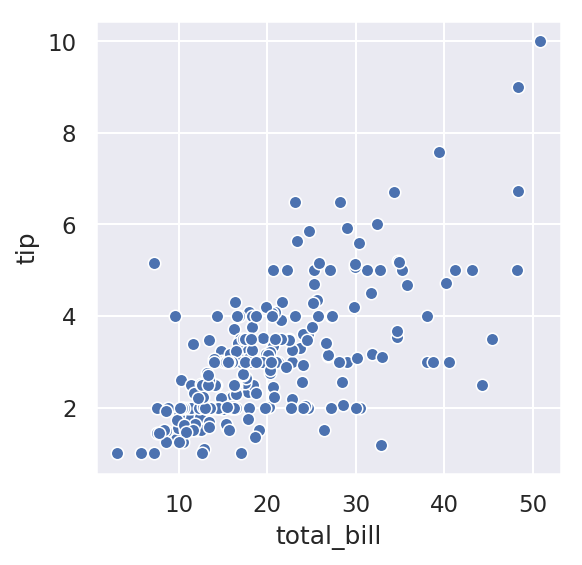

In [90]:
sns.scatterplot(tips["total_bill"], tips["tip"])

We'll use a one parameter model that the output is $\hat{\gamma}$ times the x value. For example if $\hat{\gamma} = 0.1$, then $\hat{y} = \hat{\gamma} x$, and we are making the prediction line below.

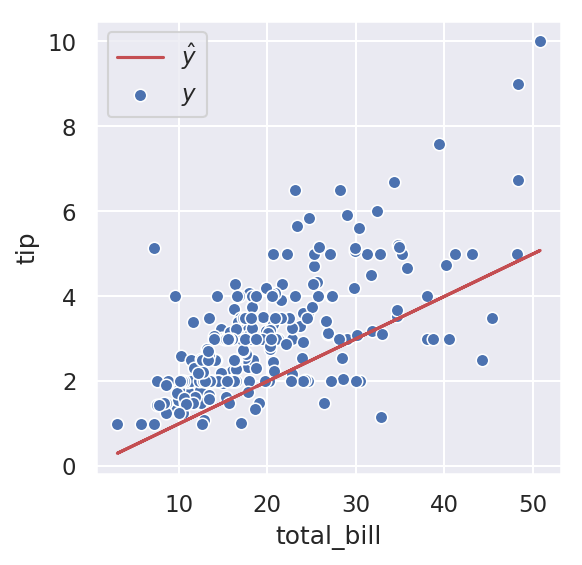

In [91]:
sns.scatterplot(tips["total_bill"], tips["tip"])
x = tips["total_bill"]
y_hat = 0.1 * x
plt.plot(x, y_hat, 'r')
plt.legend(['$\hat{y}$', '$y$'])
#plt.savefig("tip_vs_total_bill.png", dpi=300)

Suppose we select the L2 loss as our loss function. In this case, our goal will be to minimize the mean squared error. 

Let's start by writing a function that computes the MSE for a given choice of $\gamma$ on our dataset.

In [92]:
def mse_loss(gamma, x, y_obs):
    y_hat = gamma * x
    return np.mean((y_hat - y_obs) ** 2)    

In [93]:
x = tips["total_bill"]
y_obs = tips["tip"]
mse_loss(0.1, x, y_obs)

2.0777683729508194

Our goal is to find the $\hat{\gamma}$ with minimum MSE.

### Approach 1: Closed Form Solutions

On HW6, you'll show using calculus that the optimal answer is:

$$\hat{\gamma} = \frac{\sum(x_i y_i)}{\sum(x_i^2)}$$

We can calculate this value below.

In [94]:
np.sum(tips["tip"] * tips["total_bill"])/np.sum(tips["total_bill"]**2)

0.14373189527721666

Alternately, we can use the generic equation for linear regression that we derived in lecture using the definition of orthogonality.

In [95]:
X = tips[["total_bill"]]
y = tips["tip"]
np.linalg.inv(X.T @ X) @ X.T @ y

0    0.143732
dtype: float64

### Optimization Approach #2A: Plotting the MSE vs. $\hat{\gamma}$

Since `x` and `y_obs` are fixed, the only variable is `gamma`. 

For clarity, let's define a python function that returns the MSE as a function of a single argument `gamma`.

In [96]:
def mse_single_arg(gamma):
    """Returns the MSE on our data for the given gamma"""
    x = tips["total_bill"]
    y_obs = tips["tip"]
    y_hat = gamma * x
    return mse_loss(gamma, x, y_obs)

In [97]:
mse_single_arg(0.1)

2.0777683729508194

Thus we can plot the MSE as a function of `gamma`. It turns out to look pretty smooth, and quite similar to a parabola.

Text(0,0.5,'MSE')

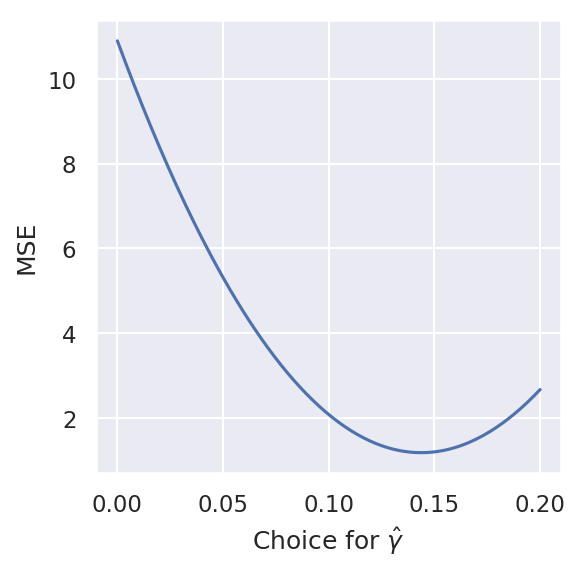

In [98]:
gammas = np.linspace(0, 0.2, 200)
x = tips["total_bill"]
y_obs = tips["tip"]

MSEs = [mse_single_arg(gamma) for gamma in gammas]

plt.plot(gammas, MSEs)
plt.xlabel(r"Choice for $\hat{\gamma}$")
plt.ylabel(r"MSE")
#plt.legend()
#plt.savefig("tips_MSE_vs_gamma.png", dpi=300, bbox_inches = "tight")

The minimum appears to be around $\hat{\gamma} = 0.14$.

### Approach 2B: Brute Force 

Recall our simple_minimize function from earlier, redefined below for your convenience.

In [99]:
def simple_minimize(f, xs):
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

In [100]:
simple_minimize(mse_single_arg, np.linspace(0, 0.2, 21))

0.14

As before, what we're doing is computing all the starred values below and then returning the $\hat{\theta}$ that goes with the minimum value.

Text(0,0.5,'MSE')

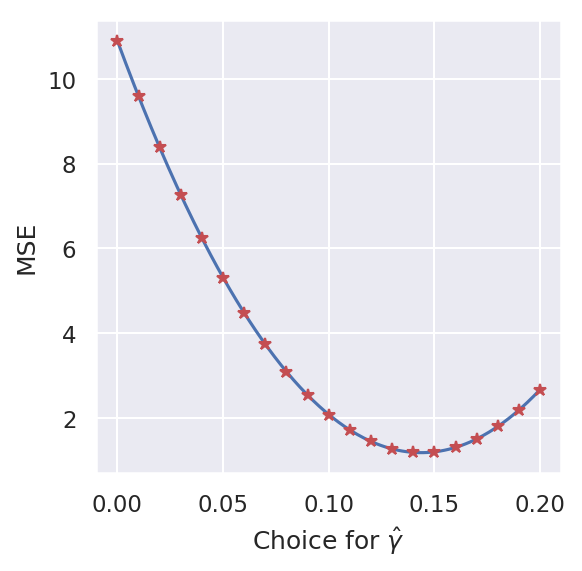

In [101]:
gammas = np.linspace(0, 0.2, 200)
sparse_gammas = np.linspace(0, 0.2, 21)

loss = [mse_single_arg(gamma) for gamma in gammas]
sparse_loss = [mse_single_arg(gamma) for gamma in sparse_gammas]

plt.plot(gammas, loss)
plt.plot(sparse_gammas, sparse_loss, 'r*')
plt.xlabel(r"Choice for $\hat{\gamma}$")
plt.ylabel(r"MSE")
#plt.savefig("tips_brute_force.png", dpi=300, bbox_inches = "tight")

### Approach 3: Use Gradient Descent

Another approach is to use our 1D gradient descent algorithm from earlier.

In [102]:
def gradient_descent(df, initial_guess, alpha, n):
    guesses = [initial_guess]
    guess = initial_guess
    while len(guesses) < n:
        guess = guess - alpha * df(guess)
        guesses.append(guess)
    return np.array(guesses)

To use this function, we need to compute the derivative of the MSE. The MSE is repeated below for convenience.

In [103]:
def mse_loss(gamma, x, y_obs):
    y_hat = gamma * x
    return np.mean((y_hat - y_obs) ** 2)    

In [104]:
def mse_loss_derivative(gamma, x, y_obs):
    y_hat = gamma * x
    return np.mean(2 * (y_hat - y_obs) * x)

In [105]:
#def squared_loss_derivative(y_hat, y_obs, x):
#    """Returns the derivative of the squared loss for a single prediction"""
#    return 2*(y_hat - y_obs)*x
#    
#def mse_derivative(y_hat, y_obs, x):
#    """Returns the derivative of the MSE"""
#    return np.mean(squared_loss_derivative(y_hat, y_obs, x))

We can try out different values of `gamma` and see what we get back as our derivative.

In [106]:
gamma = 0.1
x = tips["total_bill"]
y_obs = tips["tip"]

mse_loss_derivative(gamma, x, y_obs)

-41.143986639344256

Just like our `mse_of_gamma`, we can write a function that returns the derivative of the MSE as a function of a single argument `gamma`.

In [107]:
def mse_loss_derivative_single_arg(gamma):
    x = tips["total_bill"]
    y_obs = tips["tip"]    

    return mse_loss_derivative(gamma, x, y_obs)

In [108]:
mse_loss_derivative_single_arg(0.1)

-41.143986639344256

In [109]:
gradient_descent(mse_loss_derivative_single_arg, 0.05, 0.0001, 50)

array([0.05      , 0.05881852, 0.06680736, 0.0740446 , 0.08060095,
       0.08654045, 0.09192116, 0.09679563, 0.10121151, 0.10521192,
       0.10883597, 0.11211906, 0.11509327, 0.11778766, 0.12022855,
       0.1224398 , 0.12444301, 0.12625776, 0.12790176, 0.1293911 ,
       0.13074031, 0.13196259, 0.13306988, 0.13407298, 0.13498172,
       0.13580495, 0.13655074, 0.13722636, 0.13783841, 0.13839289,
       0.13889519, 0.13935024, 0.13976248, 0.14013593, 0.14047425,
       0.14078073, 0.14105839, 0.14130992, 0.14153778, 0.14174421,
       0.14193122, 0.14210063, 0.1422541 , 0.14239314, 0.14251909,
       0.14263319, 0.14273656, 0.1428302 , 0.14291504, 0.14299189])

In the context of minimizing loss, we can write out the gradient descent rule for generating the next $\gamma$ as:

$$
\gamma^{(t+1)} = \gamma^{(t)} - \alpha \frac{\partial}{\partial \gamma} L(\gamma^{(t)}, \Bbb{X}, \vec{\hat{y}})
$$

Here $L$ is our chosen loss function, $\Bbb{X}$ is our design matrix, and $\vec{\hat{y}}$ are our observations. During the gradient descent algorithm, we treat $\Bbb{X}$ and $\vec{\hat{y}}$ as constants.

### Approach 4: scipy.optimize.minimize

We can also use `scipy.optimize.minimize`.

In [110]:
import scipy.optimize
from scipy.optimize import minimize
minimize(mse_single_arg, x0 = 0)

      fun: 1.178116115451325
 hess_inv: array([[1]])
      jac: array([3.20374966e-06])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([0.14373189])

A natural question that arises: How does `scipy.optimize.minimize` work? We won't discuss the exact algorithm used by the code (see [this wikipedia page about the BFGS algorithm if you're curious, though](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)).

Gradient descent is related to BFGS, though generally doesn't work as well. Comparison of numerical optimization algorithms is very far beyond the scope of our course.

### Approach 5: sklearn.linear_model.LinearRegression

We can also go one level of abstraction higher and simply fit a linear model using sklearn.

In [111]:
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = False)

In [112]:
X = tips[["total_bill"]]
y = tips["tip"]
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [113]:
model.coef_

array([0.1437319])

## Multi Dimensional Models

In [114]:
#tips datset
data = sns.load_dataset("tips")
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Now suppose we improve our model so that we want to predict the tip from the total_bill plus a constant offset, in other words:

$$\textrm{tip} = \hat{\theta}_0 + \hat{\theta}_1 \textrm{bill}$$

To keep things in the simple framework from lecture, we can create a design matrix with the bias vector in one column and the total_bill in the other.

In [115]:
tips_with_bias = tips.copy()
tips_with_bias["bias"] = 1
X = tips_with_bias[["total_bill", "bias"]]
X.head(5)

,total_bill,bias
0,16.99,1
1,10.34,1
2,21.01,1
3,23.68,1
4,24.59,1


Now, we can give our predictions as $$\vec{\hat{y}} = f_{\vec{\hat{\theta}}}(\Bbb{X}) = \Bbb{X} \vec{\hat{\theta}}$$

For example, the predictions below correspond to assuming every table leaves a tip of \$1.50 plus 5% of their total bill.

In [116]:
X @ np.array([0.05, 1.50]) 

0      2.3495
1      2.0170
2      2.5505
3      2.6840
4      2.7295
        ...  
239    2.9515
240    2.8590
241    2.6335
242    2.3910
243    2.4390
Length: 244, dtype: float64

Throughout this problem, we'll assume we want to minimize the mean squared error of our predictions, i.e.

In [117]:
def mse_loss(theta, X, y_obs):
    y_hat = X @ theta
    return np.mean((y_hat - y_obs) ** 2)    

For example, the loss assuming the model described above is:

In [118]:
mse_loss(np.array([0.05, 1.50]), X, y_obs)

1.5340521752049179

### Approach 1: Closed Form Solution

In [119]:
y_obs

0      1.01
1      1.66
2      3.50
3      3.31
4      3.61
       ... 
239    5.92
240    2.00
241    2.00
242    1.75
243    3.00
Name: tip, Length: 244, dtype: float64

In [120]:
X = tips_with_bias[["total_bill", "bias"]]
X.head(5)

,total_bill,bias
0,16.99,1
1,10.34,1
2,21.01,1
3,23.68,1
4,24.59,1


In [121]:
y_obs = tips["tip"]
y_obs.head(5)

0    1.01
1    1.66
2    3.50
3    3.31
4    3.61
Name: tip, dtype: float64

In [122]:
theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y_obs
theta_hat

0    0.105025
1    0.920270
dtype: float64

In [123]:
#Note: It's generally a better idea to use np.linalg.solve.
#np.linalg.inv is slow and can sometimes return incorrect results due to rounding issues.
#np.linalg.solve is faster and generally better behaved.
theta_hat = np.linalg.solve(X.T @ X, X.T @ y_obs)

In [124]:
theta_hat

array([0.10502452, 0.92026961])

### Approach 2: Brute Force

As before, we can simply try out a bunch of theta values and see which works best. In this case, since we have a 2D theta, there's a much bigger space of possible values to try.

In [125]:
def mse_loss(theta, X, y_obs):
    y_hat = X @ theta
    return np.mean((y_hat - y_obs) ** 2)    

As before, it's convenient to first create an mse function of a single argument.

In [126]:
X = tips_with_bias[["total_bill", "bias"]]
y_obs = tips["tip"]

def mse_loss_single_arg(theta):  
    return mse_loss(theta, X, y_obs)

In [127]:
mse_loss_single_arg([0.01, 0.02])

9.479444821434425

Using this function, we can create a 3D plot. This uses lots of syntax you've never seen.

In [128]:
import plotly.graph_objects as go

uvalues = np.linspace(0, 0.2, 10)#)1)
vvalues = np.linspace(0, 2, 10)#)1)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

MSE = np.array([mse_loss_single_arg(t) for t in thetas.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

ind = np.argmin(MSE)
optimal_point = go.Scatter3d(name = "Optimal Point",
    x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
    z = [MSE[ind]],
    marker=dict(size=10, color="red"))

fig = go.Figure(data=[loss_surface, optimal_point])
fig.update_layout(scene = dict(
    xaxis_title = "theta0",
    yaxis_title = "theta1",
    zaxis_title = "MSE"))
fig.show()

### Approach 3: Gradient Descent

Gradient descent is exactly like it was before, only now our gradient is somewhat more complicated.

In [129]:
def mse_gradient(theta, X, y_obs):
    """Returns the gradient of the MSE on our data for the given theta"""    
    x0 = X.iloc[:, 0]
    x1 = X.iloc[:, 1]
    dth0 = np.mean(-2 * (y_obs - theta[0] * x0 - theta[1] * x1) * x0)
    dth1 = np.mean(-2 * (y_obs - theta[0] * x0 - theta[1] * x1) * x1)
    return np.array([dth0, dth1])

In [130]:
X = tips_with_bias[["total_bill", "bias"]]
y_obs = tips["tip"]
mse_gradient(np.array([0, 0]), X, y_obs)

array([-135.22631803,   -5.99655738])

In [131]:
def mse_gradient_single_arg(theta):
    """Returns the gradient of the MSE on our data for the given theta"""
    X = tips_with_bias[["total_bill", "bias"]]
    y_obs = tips["tip"]
    return mse_gradient(theta, X, y_obs)

In [132]:
mse_gradient_single_arg(np.array([0, 0]))

array([-135.22631803,   -5.99655738])

In [133]:
gradient_descent(mse_gradient_single_arg, np.array([0, 0]), 0.001, 20)

array([[0.        , 0.        ],
       [0.13522632, 0.00599656],
       [0.14299127, 0.00662996],
       [0.14342571, 0.00695482],
       [0.14343856, 0.00726185],
       [0.14342717, 0.00756775],
       [0.14341439, 0.00787348],
       [0.14340154, 0.00817912],
       [0.14338868, 0.00848465],
       [0.14337583, 0.00879007],
       [0.14336298, 0.0090954 ],
       [0.14335014, 0.00940062],
       [0.1433373 , 0.00970574],
       [0.14332447, 0.01001076],
       [0.14331164, 0.01031568],
       [0.14329882, 0.01062049],
       [0.14328599, 0.0109252 ],
       [0.14327318, 0.01122981],
       [0.14326036, 0.01153432],
       [0.14324756, 0.01183873]])

If you play around with the code above, you'll see that it's pretty finicky about the start point and learning rate. 

Thus, another approach is to use a more sophisticated numerical optimization library.

For reference, the general matrix form of the gradient is given below. We have not discussed how to derive this in class.

In [134]:
def mse_gradient(theta, X, y_obs):
    """Returns the gradient of the MSE on our data for the given theta"""
    n = len(X)
    return -2 / n * (X.T @ y_obs - X.T @ X @ theta)

### Approach 4: scipy.optimize.minimize

In [135]:
scipy.optimize.minimize(mse_loss_single_arg, x0 = [0, 0])

      fun: 1.0360194420114932
 hess_inv: array([[ 0.00633488, -0.1253415 ],
       [-0.1253415 ,  2.9799997 ]])
      jac: array([-2.98023224e-08, -4.47034836e-08])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.10502448, 0.92027035])

### Approach 5: sklearn.linear_model.LinearRegression

As before, we can also go one level of abstraction higher and simply fit a linear model using sklearn.

We can either do this by using our `tips_with_bias` and `fit_intercept = False`, or with our original `tips` dataframe and `fit_intercept = True`.

In [136]:
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = False)

In [137]:
X = tips_with_bias[["total_bill", "bias"]]
y = tips["tip"]
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [138]:
model.coef_

array([0.10502452, 0.92026961])

In [139]:
model = LinearRegression()
X = tips[["total_bill"]]
y = tips["tip"]
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [140]:
model.coef_

array([0.10502452])

In [141]:
model.intercept_

0.9202696135546731

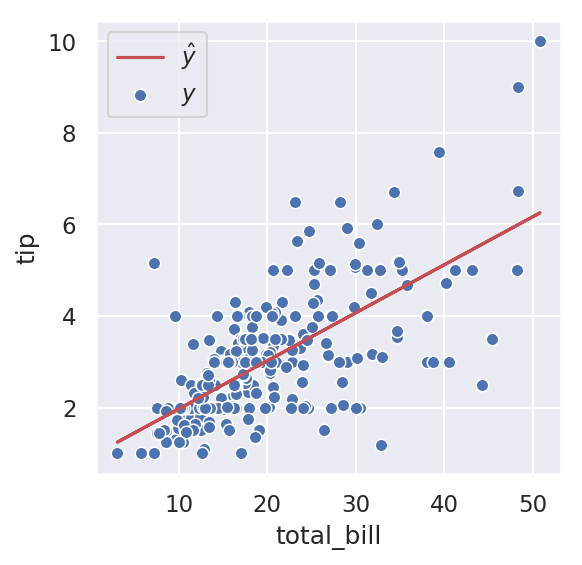

In [142]:
sns.scatterplot(tips["total_bill"], tips["tip"])
x = tips["total_bill"]
y_hat = model.intercept_ + model.coef_ * tips["total_bill"]
plt.plot(x, y_hat, 'r')
plt.legend(['$\hat{y}$', '$y$'])
#plt.savefig("tip_vs_total_bill_linear_regression.png", dpi=300)

# Logistic Regression

Our other big topic of the day is to introduce the idea of "logistic regression". Whereas we used linear regression to try to predict quantitative variables, logistic regression can be used for trying to predict a categorical variable.

In this copy of the notebook, most of the work is left blank and will be filled in live during lecture.

## NBA

In [143]:
import requests
import os

def fetch():
    path = 'nba.csv'
    if not os.path.exists(path):
        url = 'https://stats.nba.com/stats/leaguegamelog/'
        params = (
            ('Counter', '0'),
            ('DateFrom', ''),
            ('DateTo', ''),
            ('Direction', 'ASC'),
            ('LeagueID', '00'),
            ('PlayerOrTeam', 'T'),
            ('Season', '2017-18'),
            ('SeasonType', 'Regular Season'),
            ('Sorter', 'DATE'),
        )
        headers = {
            'User-Agent': 'PostmanRuntime/7.4.0'
        }
        response = requests.get(url, params=params, headers=headers)
        data = response.json()['resultSets'][0]
        df = pd.DataFrame(data=data['rowSet'], columns=data['headers'])
        df.to_csv(path, index=False)
        return df
    else:
        return pd.read_csv(path)
    
df = fetch()

### EDA

In [144]:
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22018,1610612744,GSW,Golden State Warriors,21800002,2018-10-16,GSW vs. OKC,W,240,42,...,41,58,28,7,7,21,29,108,8,1
1,22018,1610612760,OKC,Oklahoma City Thunder,21800002,2018-10-16,OKC @ GSW,L,240,33,...,29,45,21,12,6,15,21,100,-8,1
2,22018,1610612755,PHI,Philadelphia 76ers,21800001,2018-10-16,PHI @ BOS,L,240,34,...,41,47,18,8,5,16,20,87,-18,1
3,22018,1610612738,BOS,Boston Celtics,21800001,2018-10-16,BOS vs. PHI,W,240,42,...,43,55,21,7,5,15,20,105,18,1
4,22018,1610612750,MIN,Minnesota Timberwolves,21800010,2018-10-17,MIN @ SAS,L,240,39,...,32,46,20,9,2,11,27,108,-4,1


In [145]:
df.iloc[0, :]

SEASON_ID                            22018
TEAM_ID                         1610612744
TEAM_ABBREVIATION                      GSW
TEAM_NAME            Golden State Warriors
GAME_ID                           21800002
GAME_DATE                       2018-10-16
MATCHUP                        GSW vs. OKC
WL                                       W
MIN                                    240
FGM                                     42
FGA                                     95
FG_PCT                               0.442
FG3M                                     7
FG3A                                    26
FG3_PCT                              0.269
FTM                                     17
FTA                                     18
FT_PCT                               0.944
OREB                                    17
DREB                                    41
REB                                     58
AST                                     28
STL                                      7
BLK        

In [146]:
df = df.loc[:, 'SEASON_ID':'FG_PCT']
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT
0,22018,1610612744,GSW,Golden State Warriors,21800002,2018-10-16,GSW vs. OKC,W,240,42,95,0.442
1,22018,1610612760,OKC,Oklahoma City Thunder,21800002,2018-10-16,OKC @ GSW,L,240,33,91,0.363
2,22018,1610612755,PHI,Philadelphia 76ers,21800001,2018-10-16,PHI @ BOS,L,240,34,87,0.391
3,22018,1610612738,BOS,Boston Celtics,21800001,2018-10-16,BOS vs. PHI,W,240,42,97,0.433
4,22018,1610612750,MIN,Minnesota Timberwolves,21800010,2018-10-17,MIN @ SAS,L,240,39,91,0.429


In [147]:
df["WON"] = df["WL"]
df["WON"] = df["WON"].replace("W", 1)
df["WON"] = df["WON"].replace("L", 0)
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,WON
0,22018,1610612744,GSW,Golden State Warriors,21800002,2018-10-16,GSW vs. OKC,W,240,42,95,0.442,1
1,22018,1610612760,OKC,Oklahoma City Thunder,21800002,2018-10-16,OKC @ GSW,L,240,33,91,0.363,0
2,22018,1610612755,PHI,Philadelphia 76ers,21800001,2018-10-16,PHI @ BOS,L,240,34,87,0.391,0
3,22018,1610612738,BOS,Boston Celtics,21800001,2018-10-16,BOS vs. PHI,W,240,42,97,0.433,1
4,22018,1610612750,MIN,Minnesota Timberwolves,21800010,2018-10-17,MIN @ SAS,L,240,39,91,0.429,0


In [148]:
def win_rate(win_series):
    num_won = sum(win_series)
    num_played = len(win_series)
    return num_won / num_played

df.groupby("TEAM_NAME")["WON"].agg(win_rate).sort_values()

TEAM_NAME
New York Knicks           0.207317
Phoenix Suns              0.231707
Cleveland Cavaliers       0.231707
Chicago Bulls             0.268293
Atlanta Hawks             0.353659
Washington Wizards        0.390244
Dallas Mavericks          0.402439
New Orleans Pelicans      0.402439
Memphis Grizzlies         0.402439
Minnesota Timberwolves    0.439024
Los Angeles Lakers        0.451220
Sacramento Kings          0.475610
Charlotte Hornets         0.475610
Miami Heat                0.475610
Detroit Pistons           0.500000
Orlando Magic             0.512195
Brooklyn Nets             0.512195
LA Clippers               0.585366
Indiana Pacers            0.585366
San Antonio Spurs         0.585366
Oklahoma City Thunder     0.597561
Boston Celtics            0.597561
Utah Jazz                 0.609756
Philadelphia 76ers        0.621951
Portland Trail Blazers    0.646341
Houston Rockets           0.646341
Denver Nuggets            0.658537
Golden State Warriors     0.695122
Toronto Ra

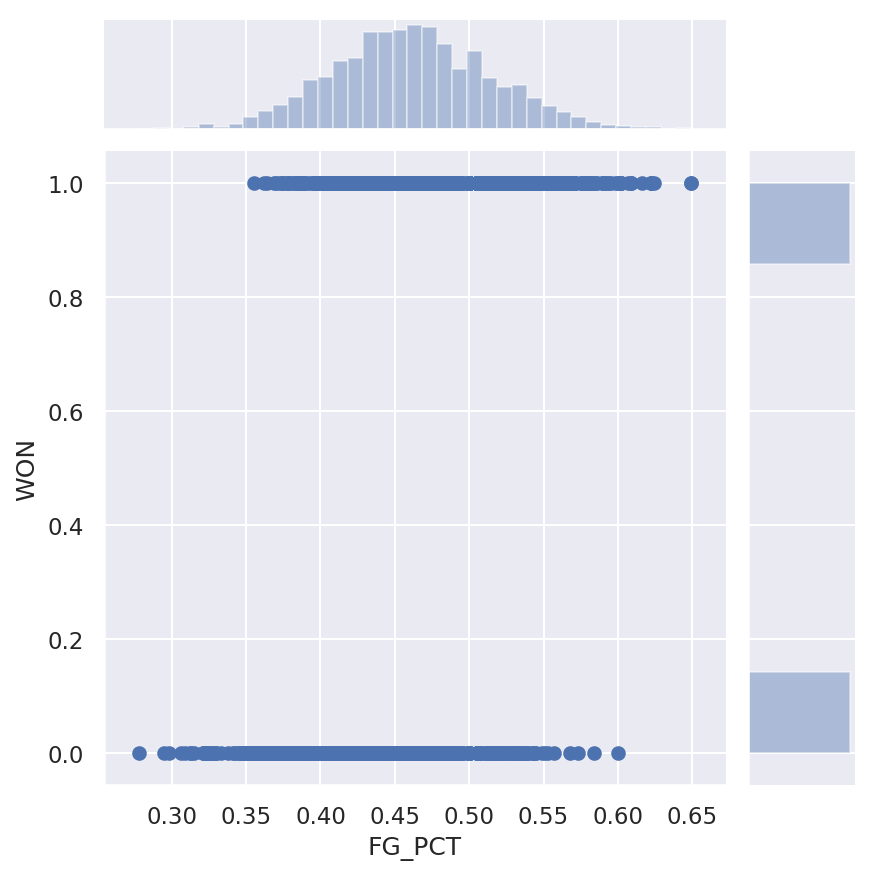

In [149]:
sns.jointplot(x = "FG_PCT", y = "WON", data = df)

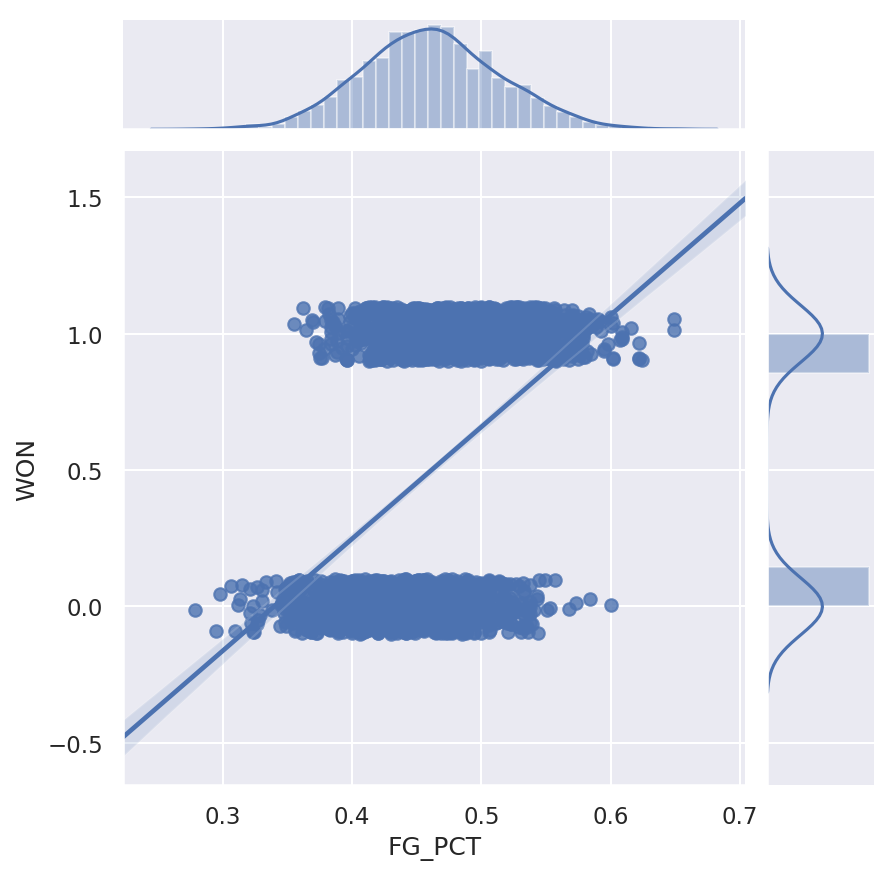

In [150]:
sns.jointplot(x = "FG_PCT", y = "WON", data = df, kind = "reg", y_jitter = 0.1)

### Adding FG_PCT_DIFF

In [151]:
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,WON
0,22018,1610612744,GSW,Golden State Warriors,21800002,2018-10-16,GSW vs. OKC,W,240,42,95,0.442,1
1,22018,1610612760,OKC,Oklahoma City Thunder,21800002,2018-10-16,OKC @ GSW,L,240,33,91,0.363,0
2,22018,1610612755,PHI,Philadelphia 76ers,21800001,2018-10-16,PHI @ BOS,L,240,34,87,0.391,0
3,22018,1610612738,BOS,Boston Celtics,21800001,2018-10-16,BOS vs. PHI,W,240,42,97,0.433,1
4,22018,1610612750,MIN,Minnesota Timberwolves,21800010,2018-10-17,MIN @ SAS,L,240,39,91,0.429,0


In [152]:
df = df[["TEAM_NAME", "GAME_ID", "FG_PCT", "WON"]]
df.head(5)

,TEAM_NAME,GAME_ID,FG_PCT,WON
0,Golden State Warriors,21800002,0.442,1
1,Oklahoma City Thunder,21800002,0.363,0
2,Philadelphia 76ers,21800001,0.391,0
3,Boston Celtics,21800001,0.433,1
4,Minnesota Timberwolves,21800010,0.429,0


In [153]:
df.groupby("GAME_ID").size()

GAME_ID
21800001    2
21800002    2
21800003    2
21800004    2
21800005    2
           ..
21801226    2
21801227    2
21801228    2
21801229    2
21801230    2
Length: 1230, dtype: int64

In [154]:
#for game_id, subframe in df.groupby("GAME_ID"):
#    print(game_id)
#    print(subframe)
    

In [155]:
one_team = df.groupby("GAME_ID").first()
one_team.head(5)

,TEAM_NAME,FG_PCT,WON
GAME_ID,,,
21800001,Philadelphia 76ers,0.391,0
21800002,Golden State Warriors,0.442,1
21800003,Milwaukee Bucks,0.494,1
21800004,Brooklyn Nets,0.488,0
21800005,Indiana Pacers,0.566,1


In [156]:
opponent = df.groupby("GAME_ID").last()
opponent.head(5)

,TEAM_NAME,FG_PCT,WON
GAME_ID,,,
21800001,Boston Celtics,0.433,1
21800002,Oklahoma City Thunder,0.363,0
21800003,Charlotte Hornets,0.446,0
21800004,Detroit Pistons,0.424,1
21800005,Memphis Grizzlies,0.298,0


In [157]:
games = one_team.merge(opponent, left_on = "GAME_ID", right_on = "GAME_ID")
games.head(5)

,TEAM_NAME_x,FG_PCT_x,WON_x,TEAM_NAME_y,FG_PCT_y,WON_y
GAME_ID,,,,,,
21800001,Philadelphia 76ers,0.391,0,Boston Celtics,0.433,1
21800002,Golden State Warriors,0.442,1,Oklahoma City Thunder,0.363,0
21800003,Milwaukee Bucks,0.494,1,Charlotte Hornets,0.446,0
21800004,Brooklyn Nets,0.488,0,Detroit Pistons,0.424,1
21800005,Indiana Pacers,0.566,1,Memphis Grizzlies,0.298,0


In [158]:
games = one_team.merge(opponent, left_on = "GAME_ID", right_on = "GAME_ID", suffixes = ["", "_OPP"])
games.head(5)

,TEAM_NAME,FG_PCT,WON,TEAM_NAME_OPP,FG_PCT_OPP,WON_OPP
GAME_ID,,,,,,
21800001,Philadelphia 76ers,0.391,0,Boston Celtics,0.433,1
21800002,Golden State Warriors,0.442,1,Oklahoma City Thunder,0.363,0
21800003,Milwaukee Bucks,0.494,1,Charlotte Hornets,0.446,0
21800004,Brooklyn Nets,0.488,0,Detroit Pistons,0.424,1
21800005,Indiana Pacers,0.566,1,Memphis Grizzlies,0.298,0


In [160]:
games = games.drop("WON_OPP", axis = 1)

In [162]:
games["FG_PCT_DIFF"] = games["FG_PCT"] - games["FG_PCT_OPP"]
games.head(5)

,TEAM_NAME,FG_PCT,WON,TEAM_NAME_OPP,FG_PCT_OPP,FG_PCT_DIFF
GAME_ID,,,,,,
21800001,Philadelphia 76ers,0.391,0,Boston Celtics,0.433,-0.042
21800002,Golden State Warriors,0.442,1,Oklahoma City Thunder,0.363,0.079
21800003,Milwaukee Bucks,0.494,1,Charlotte Hornets,0.446,0.048
21800004,Brooklyn Nets,0.488,0,Detroit Pistons,0.424,0.064
21800005,Indiana Pacers,0.566,1,Memphis Grizzlies,0.298,0.268


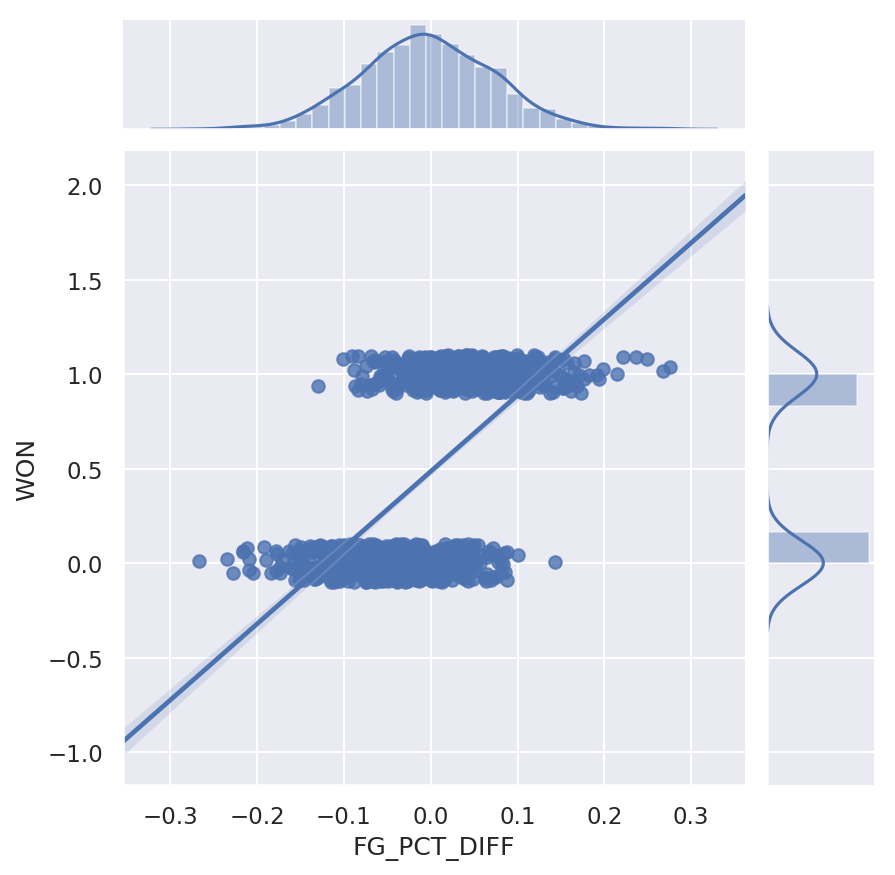

In [163]:
sns.jointplot(data = games, x = "FG_PCT_DIFF", y = "WON", y_jitter = 0.1, kind="reg")

### Modeling By Binning

Before we started linear regression, we talked about a simpler technique where you bin the data and compute the average for each bin. As an example, see the figure below from an earlier lecture:

![binned_regression.png](binned_regression.png)

### Logistic Regression (Informally)

In [165]:
bins = pd.cut(games["FG_PCT_DIFF"], 20)
bins

GAME_ID
21800001    (-0.0502, -0.0231]
21800002      (0.0582, 0.0853]
21800003      (0.0311, 0.0582]
21800004      (0.0582, 0.0853]
21800005        (0.248, 0.275]
                   ...        
21801226    (-0.0773, -0.0502]
21801227      (0.0582, 0.0853]
21801228      (-0.0231, 0.004]
21801229      (0.0582, 0.0853]
21801230    (-0.0773, -0.0502]
Name: FG_PCT_DIFF, Length: 1230, dtype: category
Categories (20, interval[float64]): [(-0.268, -0.24] < (-0.24, -0.213] < (-0.213, -0.186] < (-0.186, -0.159] ... (0.167, 0.194] < (0.194, 0.221] < (0.221, 0.248] < (0.248, 0.275]]

In [166]:
games["bin"] = bins
games.head(5)

,TEAM_NAME,FG_PCT,WON,TEAM_NAME_OPP,FG_PCT_OPP,FG_PCT_DIFF,bin
GAME_ID,,,,,,,
21800001,Philadelphia 76ers,0.391,0,Boston Celtics,0.433,-0.042,"(-0.0502, -0.0231]"
21800002,Golden State Warriors,0.442,1,Oklahoma City Thunder,0.363,0.079,"(0.0582, 0.0853]"
21800003,Milwaukee Bucks,0.494,1,Charlotte Hornets,0.446,0.048,"(0.0311, 0.0582]"
21800004,Brooklyn Nets,0.488,0,Detroit Pistons,0.424,0.064,"(0.0582, 0.0853]"
21800005,Indiana Pacers,0.566,1,Memphis Grizzlies,0.298,0.268,"(0.248, 0.275]"


In [168]:
bin_centers = [(b.left + b.right) / 2 for b in bins]
#bin_centers

In [170]:
games["bin"] = bin_centers
games.head(5)

,TEAM_NAME,FG_PCT,WON,TEAM_NAME_OPP,FG_PCT_OPP,FG_PCT_DIFF,bin
GAME_ID,,,,,,,
21800001,Philadelphia 76ers,0.391,0,Boston Celtics,0.433,-0.042,-0.03665
21800002,Golden State Warriors,0.442,1,Oklahoma City Thunder,0.363,0.079,0.07175
21800003,Milwaukee Bucks,0.494,1,Charlotte Hornets,0.446,0.048,0.04465
21800004,Brooklyn Nets,0.488,0,Detroit Pistons,0.424,0.064,0.07175
21800005,Indiana Pacers,0.566,1,Memphis Grizzlies,0.298,0.268,0.26150


In [171]:
games.groupby("bin").size()

bin
-0.25400      1
-0.22650      4
-0.19950      6
-0.17250     11
-0.14550     30
-0.11800     63
-0.09065     83
-0.06375    128
-0.03665    158
-0.00955    197
 0.01755    160
 0.04465    128
 0.07175    120
 0.09865     66
 0.12600     38
 0.15350     22
 0.18050      7
 0.20750      3
 0.23450      2
 0.26150      3
dtype: int64

In [175]:
win_rates_by_bin = games.groupby("bin")["WON"].agg(win_rate)
win_rates_by_bin

bin
-0.25400    0.000000
-0.22650    0.000000
-0.19950    0.000000
-0.17250    0.000000
-0.14550    0.000000
-0.11800    0.015873
-0.09065    0.096386
-0.06375    0.148438
-0.03665    0.227848
-0.00955    0.406091
 0.01755    0.631250
 0.04465    0.726562
 0.07175    0.858333
 0.09865    0.939394
 0.12600    1.000000
 0.15350    0.954545
 0.18050    1.000000
 0.20750    1.000000
 0.23450    1.000000
 0.26150    1.000000
Name: WON, dtype: float64

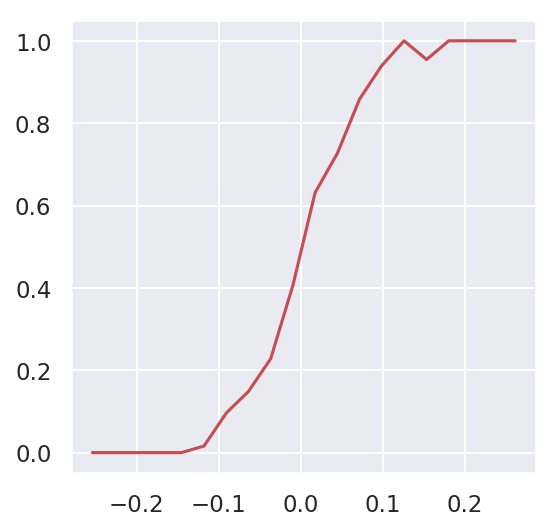

In [187]:
plt.plot(win_rates_by_bin, 'r')

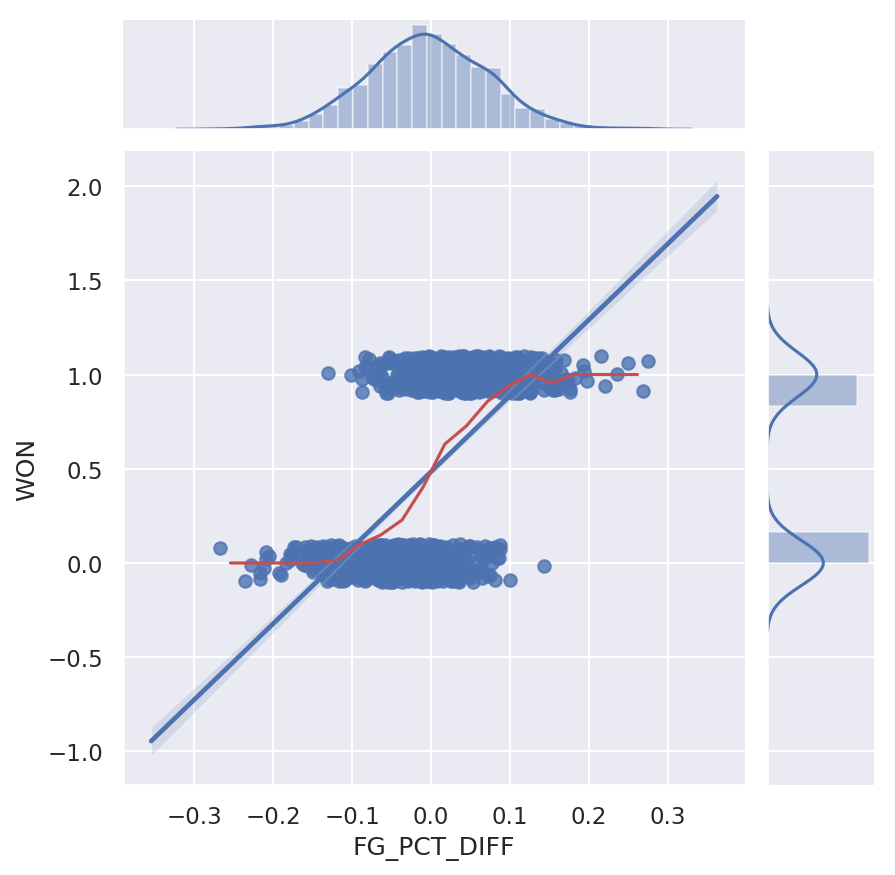

In [184]:
sns.jointplot(x = "FG_PCT_DIFF", y = "WON", data = games, kind = "reg", y_jitter = 0.1)
plt.plot(win_rates_by_bin, 'r')

In [186]:
#mystery equation
def sigma(t):
    return 1 / (1 + np.exp(-t))

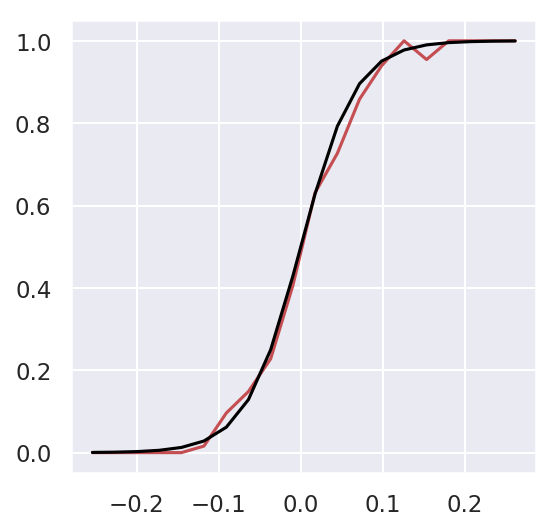

In [188]:
plt.plot(win_rates_by_bin, 'r')
x = win_rates_by_bin.index
plt.plot(x, sigma(x * 30), 'black')

Questions: Consider the 0.15350 bin.

What are:
1. $P(Y = 1 | X = 0.15350)$? 
2. $P(Y = 0 | X = 0.15350)$? 
3. $\frac{P(Y = 1 | X = 0.15350)}{P(Y = 0 | X = 0.15350)}$? In other words, how many wins are there for each loss?

In [179]:
odds_by_bin = win_rates_by_bin / (1 - win_rates_by_bin)
odds_by_bin

bin
-0.25400     0.000000
-0.22650     0.000000
-0.19950     0.000000
-0.17250     0.000000
-0.14550     0.000000
-0.11800     0.016129
-0.09065     0.106667
-0.06375     0.174312
-0.03665     0.295082
-0.00955     0.683761
 0.01755     1.711864
 0.04465     2.657143
 0.07175     6.058824
 0.09865    15.500000
 0.12600          inf
 0.15350    21.000000
 0.18050          inf
 0.20750          inf
 0.23450          inf
 0.26150          inf
Name: WON, dtype: float64

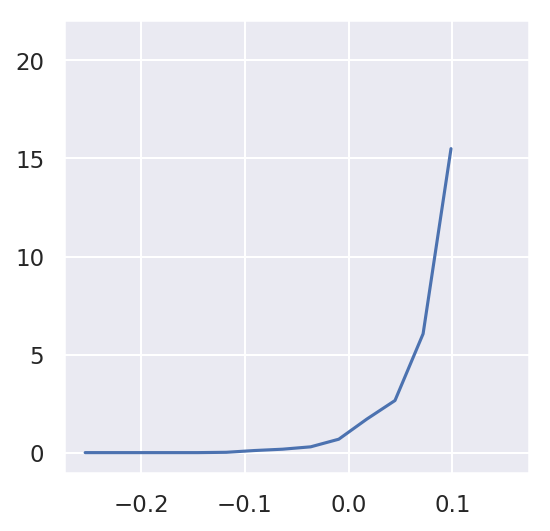

In [180]:
plt.plot(odds_by_bin)

/home/hug/miniconda3/envs/data100/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



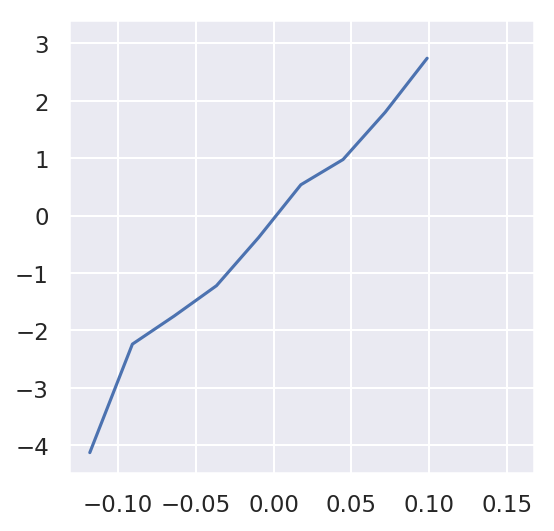

In [185]:
plt.plot(np.log(odds_by_bin))

Question: We observed that the log-odds grows linearly with X (field goal percentage). 

Using the following five symbols exactly once, write an expression that captures the statement above.

1. $\log$
2. $P(Y = 1 | X)$
3. $P(Y = 0| X)$
4. $X$
5. $\beta$

Here $\beta$ is an arbitrary constant.

## Logistic Regression

One way to model the relationship between vector-valued $X$ and the conditional distribution of a binary categorical $Y \in {0, 1}$ is to assume that the log odds ratio is linear in $X$:

$$\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) = X \beta$$

Abbreviate $P(Y=1|X)$ as $p$ and $X \beta$ as $t$, then:

\begin{align*}
\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) &= X \beta && \text{} \\[10pt]
\log \left( \frac{p}{1-p} \right) &= t && \text{; Abbreviate and complement rule} \\[10pt]
\frac{p}{1-p} &= \exp(t) && \text{; exponentiate both sides} \\[10pt]
p &= \exp(t) - p \exp(t) && \text{; multiply by $1-p$} \\[10pt]
p (1 + \exp(t)) &= \exp(t) && \text{; add $p \exp(t)$ and factor out $p$} \\[10pt]
p &= \frac{\exp(t)}{1 + \exp(t)} && \text{; divide by $1 + \exp(t)$} \\[10pt]
p &= \frac{1}{1 + \exp(-t)} && \text{; multiply by $\frac{\exp(-t)}{\exp(-t)}$} \\[10pt]
P(Y=1|X) &= \frac{1}{1 + \exp(-X \beta)} && \text{; Unabbreviate}
\end{align*}

This transformation is called the logistic function, traditionally denoted $\sigma$ (sigma).

$$\sigma(t) = \frac{1}{1 + \exp(-t)}$$

In [64]:
def sigma(t):
    return 1 / (1 + np.exp(-t))

Below, we can see how the logistic function $\frac{1}{1 + \exp(-X \beta)}$ changes as we adjust $\beta$.

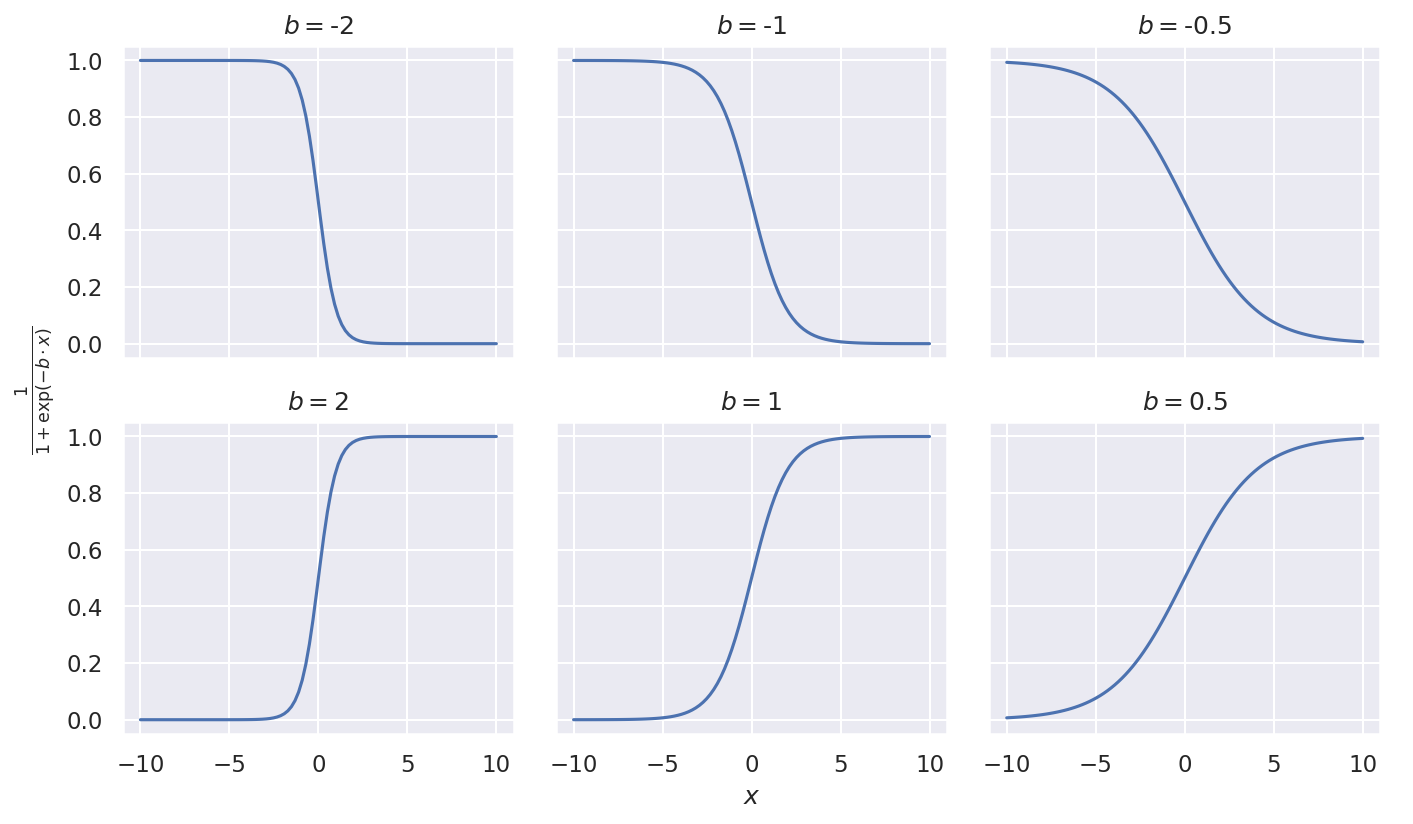

In [65]:
def flatten(li): 
    return [item for sub in li for item in sub]

bs = [-2, -1, -0.5, 2, 1, 0.5]
xs = np.linspace(-10, 10, 100)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
for ax, b in zip(flatten(axes), bs):
    ys = sigma(xs * b)
    ax.plot(xs, ys)
    ax.set_title(r'$ b = $' + str(b))

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False,
                left=False, right=False)
plt.grid(False)
plt.xlabel('$x$')
plt.ylabel(r'$ \frac{1}{1+\exp(-b \cdot x)} $')
plt.tight_layout()

## Minimizing Beta Using Squared Loss

Above, we showed that assuming the the log-odds grow linearly with X, the relationship between our prediction $P(Y = 1 | X)$ and $X$ should be given by:

$P(Y=1|X) = \frac{1}{1 + \exp(-X \beta)} = \sigma(X \beta)$

We can find the optimal $\beta$ exactly like we did with linear regression. We pick a loss function (and optionally a regularization term) and minimize the resulting function.

In [191]:
def mse_loss(beta, x, y_obs):
    y_hat = sigma(beta * x)
    return np.mean((y_hat - y_obs) ** 2)    

In [221]:
x = games["FG_PCT_DIFF"]
y_obs = games["WON"]
mse_loss(50, x, y_obs)

0.15546532360190046

In [216]:
def mse_loss_single_arg(beta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(beta * x)
    return np.mean((y_hat - y_obs) ** 2)    

Text(0.5,0,'$\\beta$')

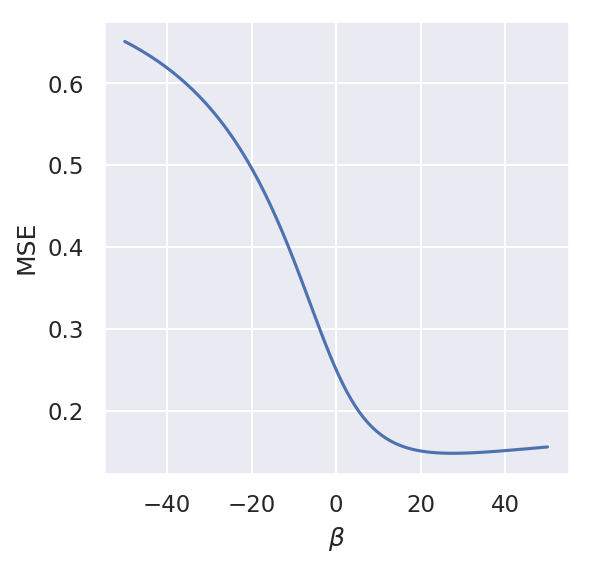

In [217]:
betas = np.linspace(-50, 50, 100)
plt.plot(betas, [mse_loss_single_arg(beta) for beta in betas])
plt.ylabel('MSE')
plt.xlabel(r'$\beta$')

In [218]:
minimize(mse_loss_single_arg, x0 = 0)

      fun: 0.1477193326045097
 hess_inv: array([[11926.98310235]])
      jac: array([-6.78002834e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 12
   status: 0
  success: True
        x: array([27.51875994])

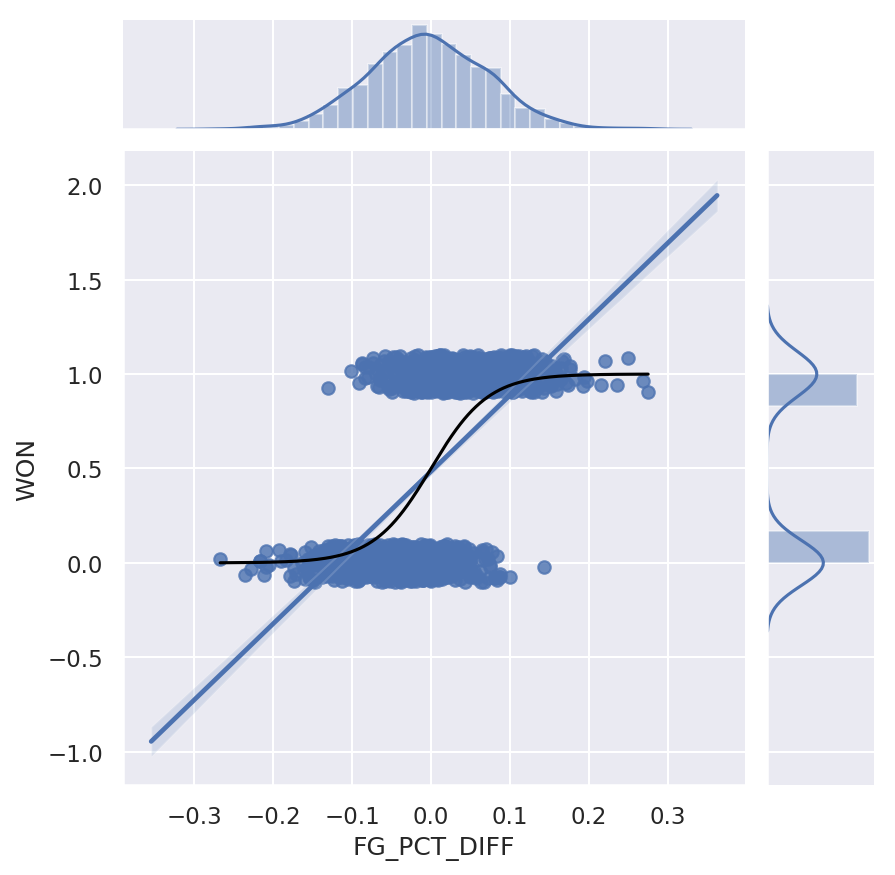

In [222]:
sns.jointplot(x = "FG_PCT_DIFF", y = "WON", data = games, kind = "reg", y_jitter = 0.1)
x = np.sort(games["FG_PCT_DIFF"])
plt.plot(x, sigma(x * 27.518), 'black')

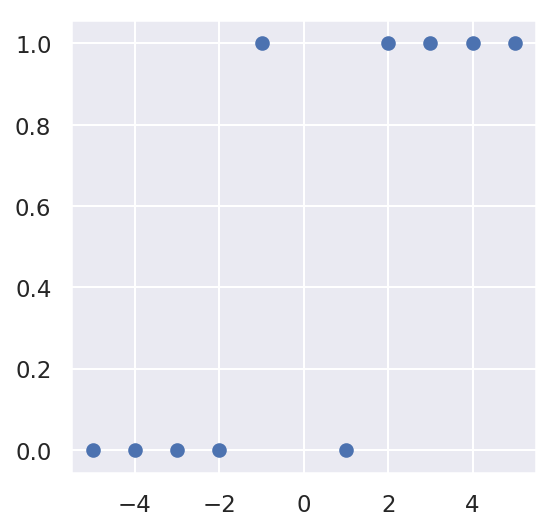

In [227]:
# non-convexity can be more of a problem, e.g. for the dataset below
toy = pd.DataFrame({
    'X': [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
    'Y': [ 0,  0,  0,  0,  1, 0, 1, 1, 1, 1]
})
plt.scatter(toy['X'], toy['Y'])
#plt.plot(toy['X'], sigma(toy['X'] * 0.63255911))

In [228]:
def mse_loss_single_arg_toy(beta):
    x = toy['X']
    y_obs = toy['Y']
    y_hat = sigma(beta * x)
    return np.mean((y_hat - y_obs) ** 2)    

Text(0.5,0,'$\\beta$')

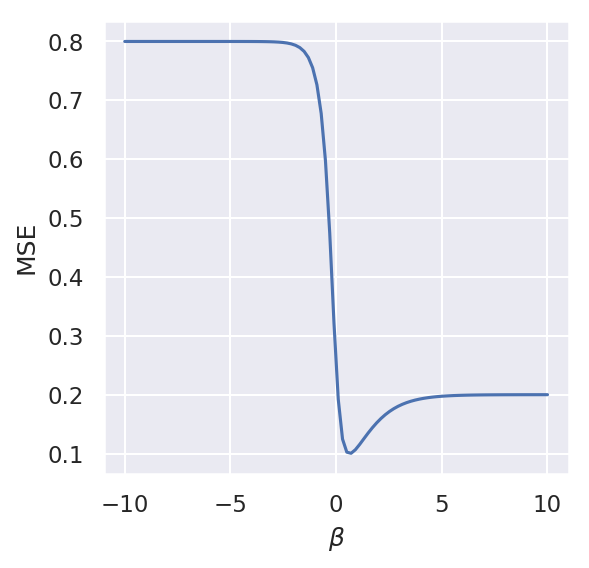

In [230]:
betas = np.linspace(-10, 10, 100)
plt.plot(betas, [mse_loss_single_arg_toy(beta) for beta in betas])
plt.ylabel('MSE')
plt.xlabel(r'$\beta$')

## Log Loss (a.k.a., Cross-Entropy Loss)

An alternate loss function often used for logistic regression is the cross-entropy loss. There are a couple of reasons that it is superior to squared loss:

1. The average loss across all the data is guaranteed to be convex, and thus easier to optimize.
2. It more strongly penalizes very bad predictions.

The cross-entropy loss is:

$$\textrm{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y})$$

In our case, since y is always either 0 or 1, we can also write the cross entropy loss as:

$$\textrm{loss} = \begin{cases}
-\log(1 - \hat{y}) & y = 0 \\
-\log(\hat{y}) & y = 1
\end{cases}$$

These two formulations are exactly identical. Even though the second is more clear conceptually, we will tend to use the first one for consistency with the outside world.

To get some intuition for what this loss function means, consider the plot below of the case where $y = 1$.

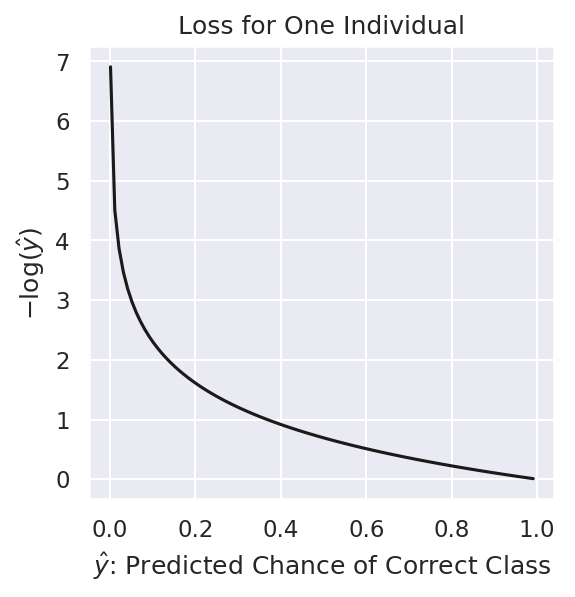

In [231]:
y_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(y_hat)
plt.plot(y_hat, loss, color='k')
plt.xlabel('$\hat{y}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(\hat{y})$')
plt.title('Loss for One Individual');

In [70]:
-np.log(0.05)

2.995732273553991

How to read this plot: Suppose the observation we're trying to predict is actually in class 1. If our model gives an 80% chance of being in class 1, the loss is relatively small (around 0.25). 

If we give only a 40% of being in class 1, the loss is larger (around 1).

If we give only a 5% chance of being in class 1, the loss is 3.

And if we give a 0% chance of being in class 1, the loss is infinite.

Let's try plotting the average cross entropy loss on our NBA data example. First, recall that the squared loss was non-convex.

In [233]:
def mse_loss_single_arg(beta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(beta * x)
    return np.mean((y_hat - y_obs) ** 2)    

Text(0.5,0,'$\\beta$')

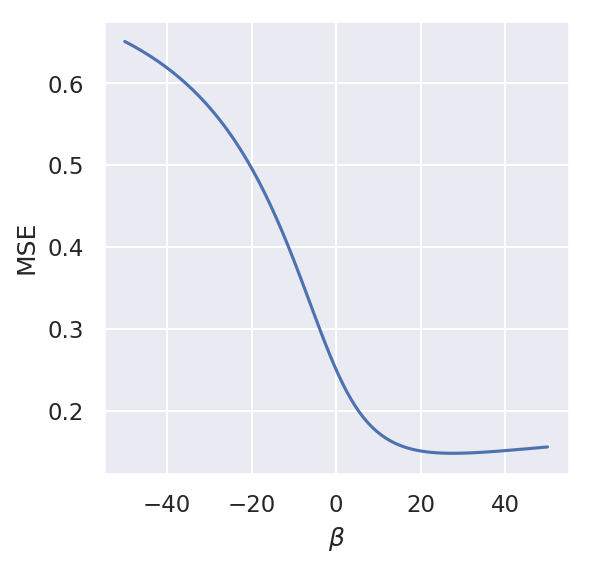

In [234]:
betas = np.linspace(-50, 50, 100)
plt.plot(betas, [mse_loss_single_arg(beta) for beta in betas])
plt.ylabel('MSE')
plt.xlabel(r'$\beta$')

By contrast, the cross entropy loss is shown below:

In [235]:
def cross_entropy_loss(y, y_hat):
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

def cross_entropy_loss_single_arg(beta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(beta * x)
    return np.mean(cross_entropy_loss(y_obs, y_hat))

Text(0.5,0,'$\\beta$')

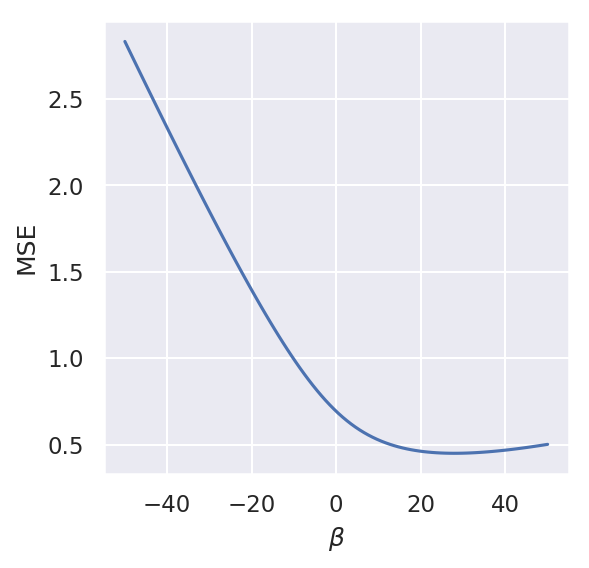

In [236]:
betas = np.linspace(-50, 50, 100)
plt.plot(betas, [cross_entropy_loss_single_arg(beta) for beta in betas])
plt.ylabel('MSE')
plt.xlabel(r'$\beta$')

As you can see above, this loss function is convex. It turns out (but we will not prove) that this is always the case for logistic regression.

Finally we can optimize. We've chosen to use scipy.optimize.minimize, but we could also use our gradient descent from before if we compute the derivative of our loss function.

In [237]:
minimize(cross_entropy_loss_single_arg, x0 = 0)

      fun: 0.45040966861676207
 hess_inv: array([[2990.1602976]])
      jac: array([-5.04031777e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 7
     njev: 11
   status: 0
  success: True
        x: array([27.91522753])